## Supervised machine learning

**Goal:** predict the time in hours of absenteisme. In the context of the problem we don't really need to get the time down to the minute but rather a global estimation of: is this employee going to be absent for 1/2 day or rather 2 days? 

**Type of supervised learning:** I will use classification model such as Decisiion Tree to get a prediction on the range of absenteeism. Decision Tree model will allow to deal with categorical data because I have many of them in the dataset.

Though regression model would work on the target type of data, I will keep it as a way for improvement if classification models fail. 

**Preprocessing and modelling tasks:** 
- [x] Drop id column which is irrelevant for modelling
- [x] Check types of columns an ensure the categorical data are well identified
- [x] Check for multicollinearity and drop columns with high correlation
- [x] Check distribution and choose the right scaling method
- [x] Check for balance of dataset and over/under sampling if needed
- [x] Create train/test samples 
- [x] Build Decision tree model 
- [x] Check performance of model using accuracy score, visualize confusion matrix using heatmap 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('../data/absenteeism_clusterized.csv')
print(df.shape)
df.head()

(697, 11)


,id,reason_for_absence,month_of_absence,day_of_the_week,seasons,service_time,work_load_average_day,hit_target,absenteeism_bins,total_disciplinary_failures,cluster
0,11,26,7,3,1,13,239.554,97,"(2.0, 4.0]",2,2
1,11,23,7,5,1,13,239.554,97,"(-0.001, 2.0]",2,2
2,11,18,8,2,1,13,205.917,92,"(4.0, 8.0]",2,2
3,11,23,8,3,1,13,205.917,92,"(-0.001, 2.0]",2,2
4,11,18,8,4,1,13,205.917,92,"(4.0, 8.0]",2,2


In [3]:
# Splitting dataset into features and target dataframes

X = df.drop('absenteeism_bins',axis=1).copy()
print(X.shape)

y = df.absenteeism_bins
print(y.shape)

(697, 10)
(697,)


__________________________
## Preprocessing

In [4]:
# Dropping Id columns because it has no impact on predicting the time of absence
X.drop('id', axis=1, inplace= True)

In [5]:
# Convert categorical dtypes to object

X[['reason_for_absence',
   'month_of_absence',
   'day_of_the_week',
   'seasons','cluster']] = X[['reason_for_absence',
                              'month_of_absence',
                              'day_of_the_week',
                              'seasons','cluster']].astype(object)
X.dtypes

reason_for_absence              object
month_of_absence                object
day_of_the_week                 object
seasons                         object
service_time                     int64
work_load_average_day          float64
hit_target                       int64
total_disciplinary_failures      int64
cluster                         object
dtype: object

In [6]:
# Checking dtype of target 

y.dtype

dtype('O')

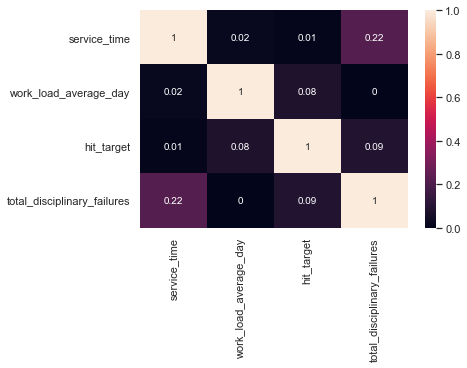

In [7]:
# Checking multicollinearity through data visualization

sns.heatmap(abs(X.corr().round(2)), annot=True);

In [8]:
# Checking multicollinearity between numeric columns using VIF metrics

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

def drop_check_vif(column, X):
    if column:
        X=X.drop(column, axis=1)
    vifs=pd.Series([VIF(X.values,i) for i in range(X.shape[1])],index=X.columns)
    display(vifs[vifs>10])
    return X

In [9]:
# Creating a list of col to drop for multicollinearity (numeric columns)
col_drop = []
X_num = X._get_numeric_data()

In [10]:
col_drop.append('hit_target')

X_num = drop_check_vif(col_drop[-1], X_num)

Series([], dtype: float64)

I dropped 1 column with VIF above 10: hit_target

In [11]:
# Dropping columns with high multicollinearity

X.drop(columns=col_drop[-1],inplace=True)
print(X.shape)

(697, 8)


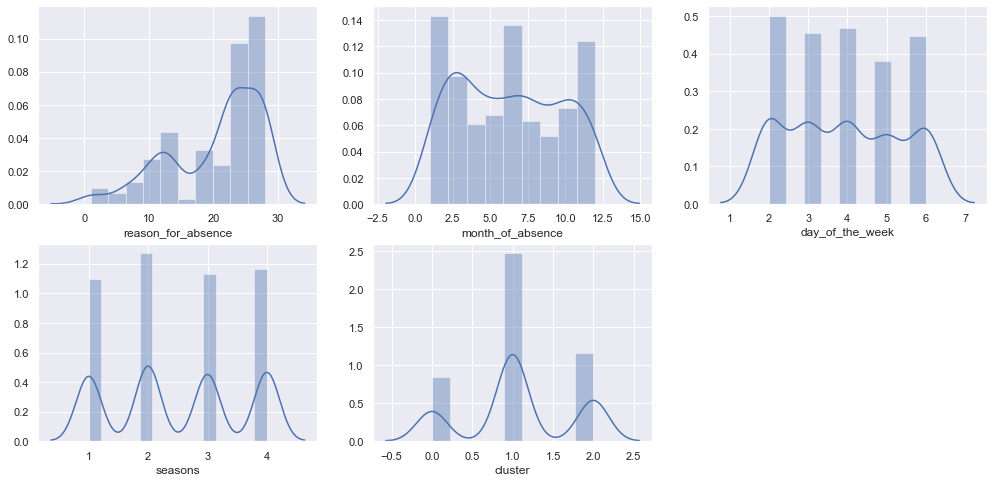

In [12]:
# Checking the frequency distribution of categorical features
cat_features = X[X.columns[X.dtypes==object]]

fig, axs=plt.subplots(2,3, figsize=(17,8))

for i in range(cat_features.shape[1]):
    ax=axs[i//3,i%3]
    sns.distplot(cat_features.iloc[:,i],ax=ax)

fig.delaxes(ax=axs[1,2])
plt.show()

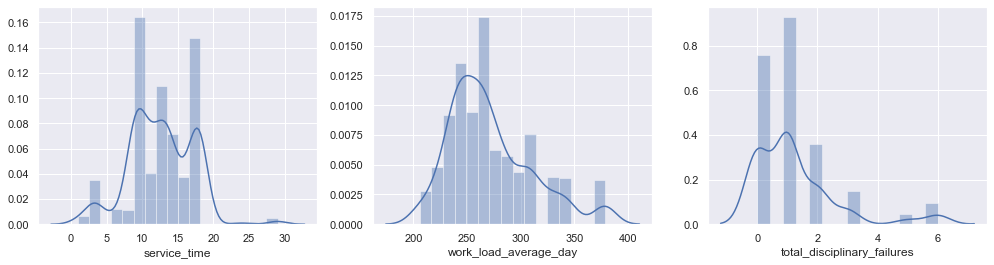

In [13]:
# Checking the frequency distribution of numeric features
fig, axs=plt.subplots(1,3, figsize=(17,4))

for i in range(X_num.shape[1]):
    sns.distplot(X_num.iloc[:,i],ax=axs[i])

plt.show()

In [14]:
# Apply standardization because scale of values is the same for all

from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_num_scaled = sc_X.fit_transform(X_num)

X[X.columns[X.columns.isin(X_num.columns)]] = X_num_scaled
X.head()

,reason_for_absence,month_of_absence,day_of_the_week,seasons,service_time,work_load_average_day,total_disciplinary_failures,cluster
0,26,7,3,1,0.101582,-0.810571,0.53861,2
1,23,7,5,1,0.101582,-0.810571,0.53861,2
2,18,8,2,1,0.101582,-1.671611,0.53861,2
3,23,8,3,1,0.101582,-1.671611,0.53861,2
4,18,8,4,1,0.101582,-1.671611,0.53861,2


In [15]:
X.dtypes

reason_for_absence              object
month_of_absence                object
day_of_the_week                 object
seasons                         object
service_time                   float64
work_load_average_day          float64
total_disciplinary_failures    float64
cluster                         object
dtype: object

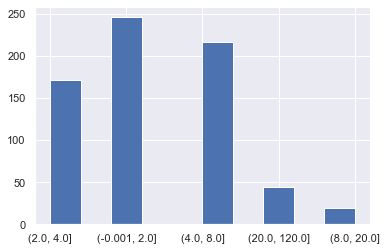

In [16]:
# Checking balance of dataset
y.hist();

### Conclusion on preprocessing

We have imbalanced dataset regarding the frequency distribution of targets but this is normal because the categories with low frequency are outliers. 

Distribution of numeric features are not normally dstributed. We can assume that Decision Tree is not sensitive to normal distribution of data so we will keep them as it is. 

We can see that the categorical data are kinda uniformly distributed for seasons and day_of_week, so they may not affect much the model. 

We will build the model as it is and see for application of possible improvements afterwards.

**Possible improvements:** 
- Apply over and under sampling methods to balance the dataset if imbalance of dataset has too much effect
- Apply box-cox transformation if normallity would improve the performance of the model

_______________________
## Modelling

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score

In [18]:
# Creating samples for train and test data
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size = 0.3, random_state=42, stratify=y)

print('Checking shape of samples')
print('X_train',X_train.shape)
print('X_test',X_test.shape,'\n')
print('Checking stratify of samples')
print('y_train\n',y_train.value_counts(normalize=True))
print('y_test\n', y_test.value_counts(normalize=True))

Checking shape of samples
X_train (487, 8)
X_test (210, 8) 

Checking stratify of samples
y_train
 (-0.001, 2.0]    0.353183
(4.0, 8.0]       0.310062
(2.0, 4.0]       0.246407
(20.0, 120.0]    0.063655
(8.0, 20.0]      0.026694
Name: absenteeism_bins, dtype: float64
y_test
 (-0.001, 2.0]    0.352381
(4.0, 8.0]       0.309524
(2.0, 4.0]       0.247619
(20.0, 120.0]    0.061905
(8.0, 20.0]      0.028571
Name: absenteeism_bins, dtype: float64


In [19]:
# Building model
dtree = DecisionTreeClassifier(random_state=8)
dtree = dtree.fit(X_train, y_train)

y_pred_dtree = dtree.predict(X_test)

# Checking performance of model using evaluation metrics
print("Accuracy score:",accuracy_score(y_test,y_pred_dtree))

# Checking overfitting of model by checking the accuracy of train sample
y_train_pred = dtree.predict(X_train)
print("Accuracy score for train sample:",accuracy_score(y_train,y_train_pred))

Accuracy score: 0.4380952380952381
Accuracy score for train sample: 0.9794661190965093


In [20]:
feat_importance_dt = pd.DataFrame(dtree.feature_importances_, index=X.columns)
feat_importance_dt

,0
reason_for_absence,0.285303
month_of_absence,0.075251
day_of_the_week,0.138062
seasons,0.050734
service_time,0.145380
work_load_average_day,0.126704
total_disciplinary_failures,0.109237
cluster,0.069330


In [21]:
set(y.values)

{'(-0.001, 2.0]', '(2.0, 4.0]', '(20.0, 120.0]', '(4.0, 8.0]', '(8.0, 20.0]'}

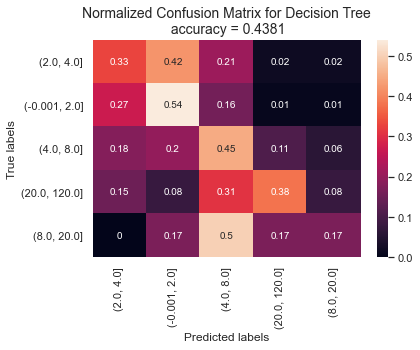

In [22]:
ac_score = accuracy_score(y_test,y_pred_dtree)
class_names = y.unique()

sns.heatmap(confusion_matrix(y_test,y_pred_dtree, labels=class_names, normalize='true').round(2), annot=True, xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.title(f'Normalized Confusion Matrix for Decision Tree\n accuracy = {ac_score.round(4)}', fontsize=14)
plt.savefig('../img/norm_confusion_matrix_decision_tree.png')
plt.show()

### Conclusion on Decision Tree

The accuracy score is not so good and we can see there is an overfit of train sample, which can be frequent for Decision tree. 

In the stratify we clearly see the imbalance of target, we may want to correct that to see if there is improvement of accuracy (but we should keep in mind that the imbalance is due to outliers we may want to keep track on). 

**Possible improvements:**
- Use crossvalidation to avoid overfitting
- Test Random Forest which is better to handle overfitting
- Under/over sampling dataset

___________________________
## Use Cross validation for Decision Tree

In [23]:
from sklearn.model_selection import StratifiedKFold # Use of Stratified to keep imbalanced samples

list_of_accuracies=[]
skf = StratifiedKFold(n_splits=4, random_state=8, shuffle=True) 
dtree_cv = DecisionTreeClassifier(random_state=8)

for train_idx, test_idx in skf.split(X,y):
    dtree_cv = dtree_cv.fit(X.iloc[train_idx,:],y[train_idx])
    list_of_accuracies.append(accuracy_score(y[test_idx],dtree_cv.predict(X.iloc[test_idx,:])))
    
print("Average accuracy:",np.mean(list_of_accuracies))

Average accuracy: 0.4735632183908046


In [29]:
from sklearn.model_selection import cross_val_score

dtree_cv = DecisionTreeClassifier(random_state=8)
csv = cross_val_score(dtree_cv, X, y, cv=4)
print(csv)
print("Average accuracy:",np.mean(csv))

[0.41714286 0.29885057 0.36781609 0.35057471]
Average accuracy: 0.3585960591133005


### Conclusion ofr cross-validation 

We can see there is no such improvement of the model accuracy using cross-validation.

So we should use Random Forest to check the accuracy and make sure the overfitting is not the problem. Altough we may want to keep cross-validation. 

_______________
## Random Forest 

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
list_of_accuracies=[]
skf = StratifiedKFold(n_splits=4, random_state=8, shuffle=True) 
randomf = RandomForestClassifier(random_state=8)

for train_idx, test_idx in skf.split(X,y):
    randomf = randomf.fit(X.iloc[train_idx,:],y[train_idx])
    list_of_accuracies.append(accuracy_score(y[test_idx],randomf.predict(X.iloc[test_idx,:])))
    
print("Average accuracy:",np.mean(list_of_accuracies))
list_of_accuracies

Average accuracy: 0.5638752052545155


[0.5428571428571428,
 0.5747126436781609,
 0.5459770114942529,
 0.5919540229885057]

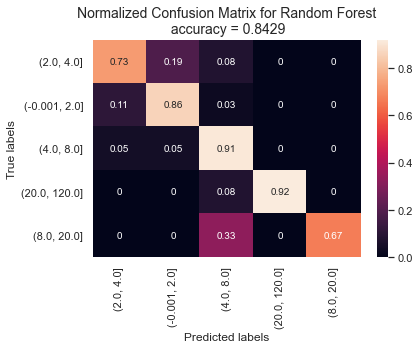

In [27]:
y_pred_rf = randomf.predict(X_test)
ac_score = accuracy_score(y_test,y_pred_rf)

sns.heatmap(confusion_matrix(y_test,y_pred_rf, labels=class_names, normalize='true').round(2), annot=True, xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.title(f'Normalized Confusion Matrix for Random Forest\n accuracy = {ac_score.round(4)}', fontsize=14)
plt.savefig('../img/norm_confusion_matrix_random_forest.png')
plt.show()

In [28]:
# Compare feature importance between Decision Tree and Random Forest

feat_importance_rf = pd.DataFrame(randomf.feature_importances_,index=X.columns)

feat_importance = pd.merge(feat_importance_dt,feat_importance_rf, left_index=True, right_index=True, suffixes=('_dt','_rf'))
feat_importance


,0_dt,0_rf
reason_for_absence,0.285303,0.266329
month_of_absence,0.075251,0.115428
day_of_the_week,0.138062,0.127836
seasons,0.050734,0.060761
service_time,0.145380,0.131098
work_load_average_day,0.126704,0.166109
total_disciplinary_failures,0.109237,0.080859
cluster,0.069330,0.051579


### Conclusion on Random Forest

Accuracy of model is much better with Random Forest so we can see it handle the overfitting of Decision tree model and the imbalanced of the dataset didn't affect too much the results. 

When checking at the feature importance, there are quite the same between random forest model and decision tree model, the performance of random forest is just better. 

**Prossible improvements:**
- Under/over sampling dataset to check if accuracy is better without keep outliers in low number
- Test other decision-tree-like models such as Xgboost, Catboost and Adaboost